In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns

### データ読み込み

In [2]:
df = pd.read_csv('/home/banban/junior_ws/matuo/data.csv')

### 辞職有無の割合

/tmp/ipykernel_1989/1932257344.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['Attrition'], ax=ax[1], palette=['#1f77b4', '#ff7f0e'])


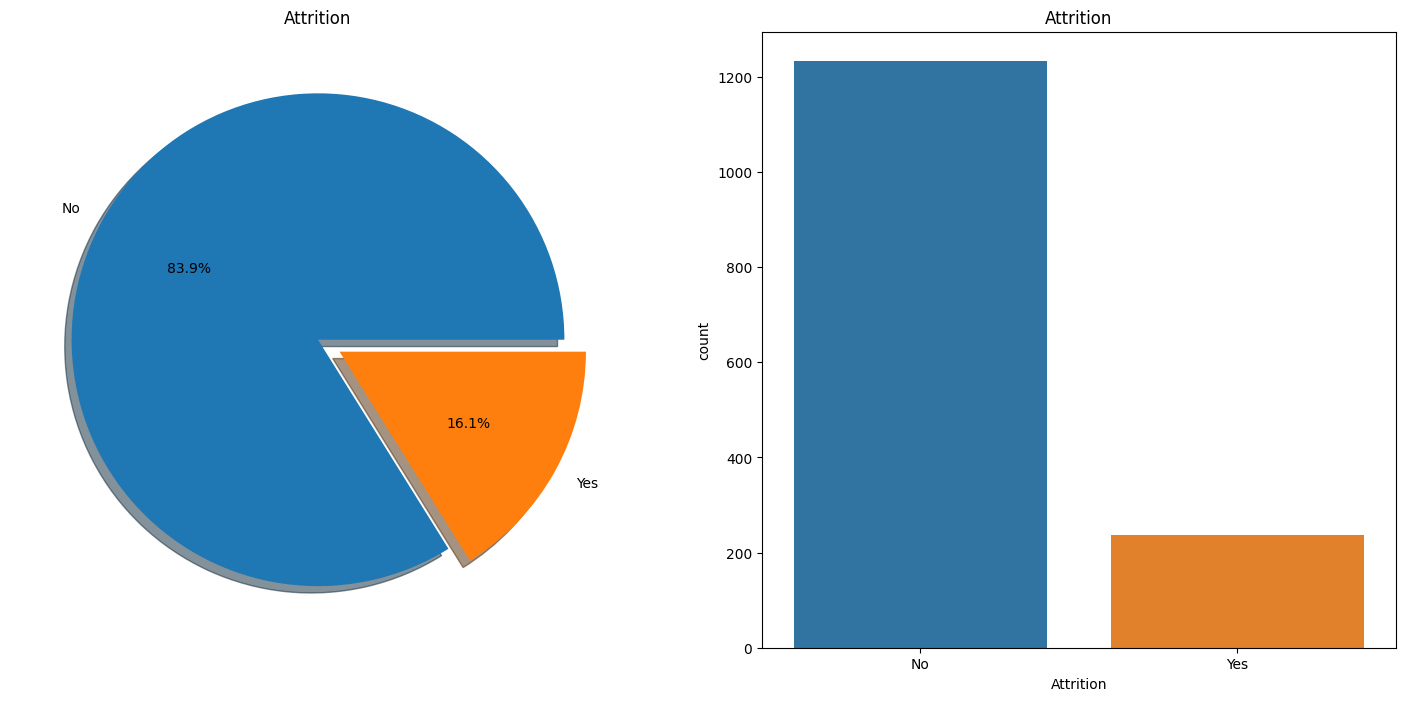

In [3]:
# プロットの準備
f, ax = plt.subplots(1, 2, figsize=(18, 8))

# 左側の円グラフ
df['Attrition'].value_counts().plot.pie(
    explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True, colors=['#1f77b4', '#ff7f0e']
)
ax[0].set_title('Attrition')
ax[0].set_ylabel('')

# 右側の棒グラフ
sns.countplot(x=df['Attrition'], ax=ax[1], palette=['#1f77b4', '#ff7f0e'])
ax[1].set_title('Attrition')

# 表示
plt.show()

### one-hot 用

In [4]:
categ_nominal = ["JobInvolvement",'BusinessTravel', 'Department', "Education","PerformanceRating",'EducationField', 'Gender',"EnvironmentSatisfaction",
       'JobRole', 'MaritalStatus', 'Over18', 'OverTime', 'HowToEmploy']

In [5]:
for i in categ_nominal:
    df = pd.concat([df, pd.get_dummies(df[i], prefix=i, dummy_na=True)], sort=False, axis=1)
df = df.drop(categ_nominal, axis=1)

df['Attrition'] = df['Attrition'].replace({'Yes': 1, 'No': 0}).astype(bool)


df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 90 columns):
 #   Column                                Non-Null Count  Dtype
---  ------                                --------------  -----
 0   Age                                   1470 non-null   int64
 1   Attrition                             1470 non-null   bool 
 2   DailyAchievement                      1470 non-null   int64
 3   DistanceFromHome                      1470 non-null   int64
 4   EmployeeCount                         1470 non-null   int64
 5   EmployeeNumber                        1470 non-null   int64
 6   HourlyAchievement                     1470 non-null   int64
 7   JobLevel                              1470 non-null   int64
 8   JobSatisfaction                       1470 non-null   int64
 9   MonthlyIncome                         1470 non-null   int64
 10  MonthlyAchievement                    1470 non-null   int64
 11  NumCompaniesWorked                    1470 

/tmp/ipykernel_1989/4071594821.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Attrition'] = df['Attrition'].replace({'Yes': 1, 'No': 0}).astype(bool)


### 辞職有無に対する重要特徴量予測

In [6]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb

ここで、業務業績が4.0と高い人のみにデータを絞る

In [7]:
# performance_rating_4.0 == 1 のデータを抽出
filtered_data = df[df['PerformanceRating_4.0'] == True]

# 目的変数 (Attrition) を確認
X_filtered = filtered_data.drop('Attrition', axis=1)
y_filtered = filtered_data['Attrition']

# トレーニングデータとテストデータに分割
X_train, X_valid, y_train, y_valid = train_test_split(
    X_filtered, y_filtered, test_size=0.2, random_state=0
)

In [8]:
# 学習に使用するデータを設定
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

# パラメータ
params = {
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1,
}


# モデルの学習
model = lgb.train(params,
                  train_set=lgb_train, # トレーニングデータの指定
                  valid_sets=lgb_eval, # 検証データの指定
                  )

# テストデータの予測
y_pred = model.predict(X_valid)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

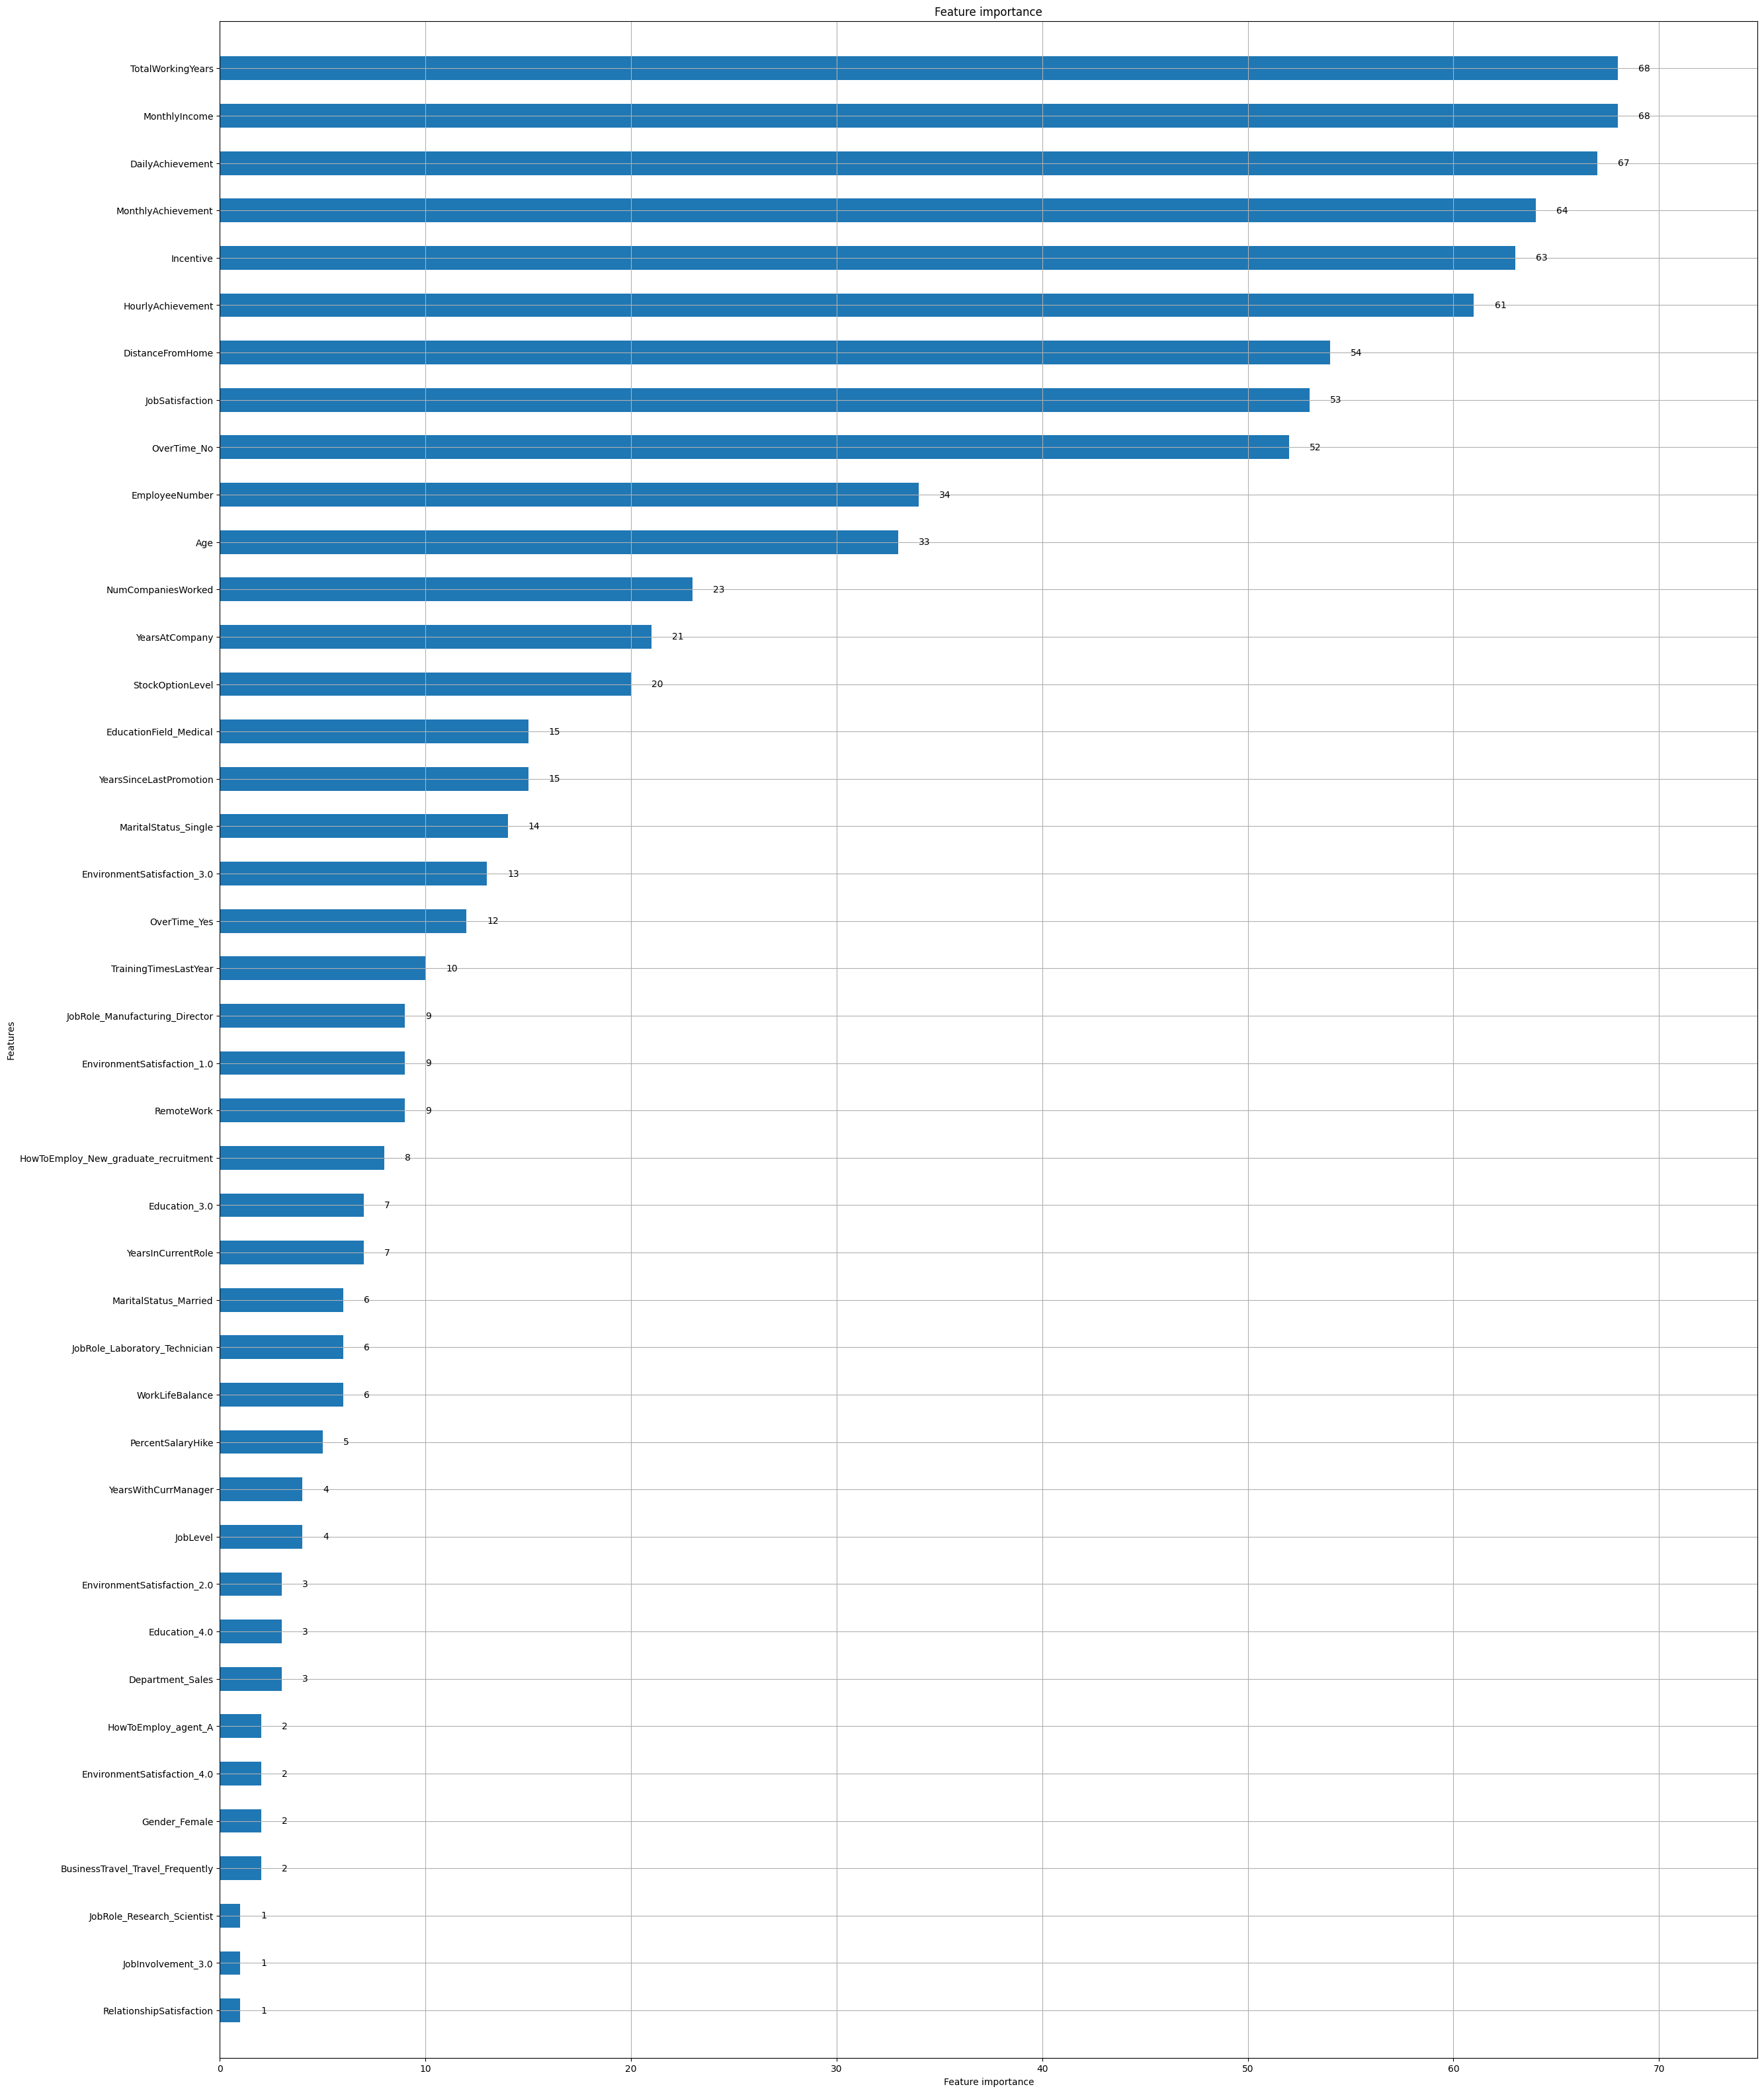

In [9]:
lgb.plot_importance(model, height=0.5, figsize=(30,40))

### 相関係数

<Axes: >

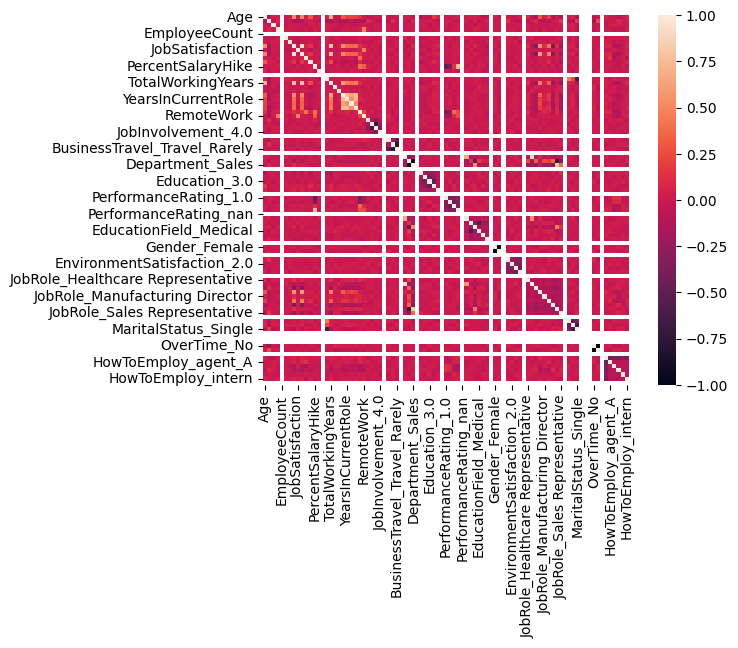

In [10]:
corr=df.corr()
sns.heatmap(corr, square=True, annot=False)

In [11]:
corr['Attrition'].sort_values(ascending=False).head(30)

Attrition                           1.000000
OverTime_Yes                        0.246118
MaritalStatus_Single                0.175419
JobRole_Sales Representative        0.157234
EnvironmentSatisfaction_1.0         0.122819
JobInvolvement_1.0                  0.117161
BusinessTravel_Travel_Frequently    0.115143
JobRole_Laboratory Technician       0.098290
HowToEmploy_agent_C                 0.089298
Department_Sales                    0.080855
DistanceFromHome                    0.077924
EducationField_Technical Degree     0.069355
EducationField_Marketing            0.055781
JobInvolvement_2.0                  0.044731
NumCompaniesWorked                  0.043494
PerformanceRating_1.0               0.036671
EducationField_Human Resources      0.036466
JobRole_Human Resources             0.036215
Gender_Male                         0.029453
PerformanceRating_2.0               0.027160
Education_3.0                       0.025723
Education_1.0                       0.020777
JobRole_Sa

## 仮説検定

### 辞職有無と勤務年数

Attrition
False    Axes(0.125,0.11;0.775x0.77)
True     Axes(0.125,0.11;0.775x0.77)
Name: TotalWorkingYears, dtype: object

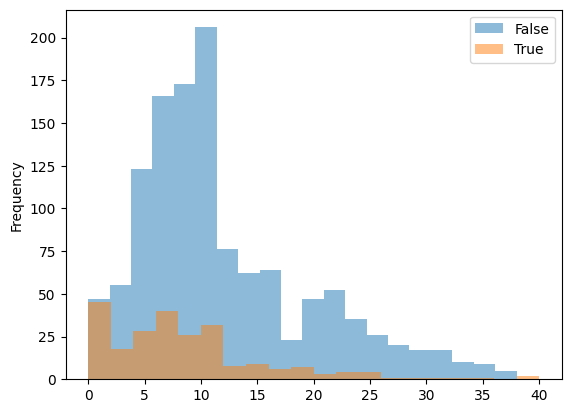

In [12]:
df.groupby('Attrition')['TotalWorkingYears'].plot.hist(bins=20, alpha=0.5, legend=True)

帰無仮説棄却

In [13]:
from scipy import stats
df_copy=df.copy()
df_copy.dropna(inplace=True)
s, pvalue = stats.mannwhitneyu(df_copy[df_copy["Attrition"]==True]["TotalWorkingYears"]
                , df_copy[df_copy["Attrition"]==0]["TotalWorkingYears"]
                ,alternative='two-sided')
pvalue < 0.05

np.True_

### 辞職有無と月収

Attrition
False    Axes(0.125,0.11;0.775x0.77)
True     Axes(0.125,0.11;0.775x0.77)
Name: MonthlyIncome, dtype: object

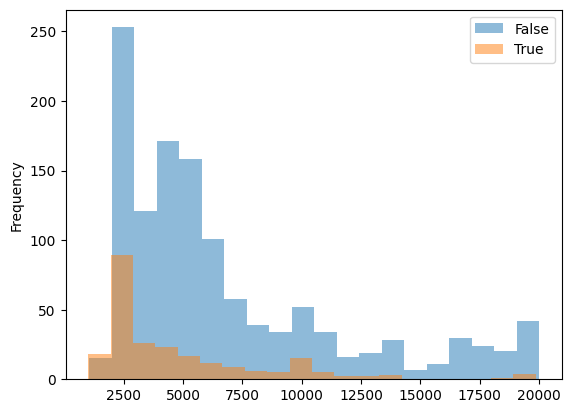

In [14]:
df.groupby('Attrition')['MonthlyIncome'].plot.hist(bins=20, alpha=0.5, legend=True)

帰無仮説棄却

In [15]:
from scipy import stats
df_copy=df.copy()
df_copy.dropna(inplace=True)
s, pvalue = stats.mannwhitneyu(df_copy[df_copy["Attrition"]==True]["MonthlyIncome"]
                , df_copy[df_copy["Attrition"]==0]["MonthlyIncome"]
                ,alternative='two-sided')
pvalue < 0.05

np.True_